In [11]:
import pandas as pd
import json
import numpy as np
from rich import print
import torch
import matplotlib.pyplot as plt
from ravl.discover import discover
from ravl.zeroshot_utils import zero_shot_cls, get_templates_for_mnist

# Discovering Spurious Correlations with RaVL 
In this notebook, we demonstrate how RaVL can be utilized to discover spurious correlations learned by a fine-tuned VLM. In this scenario, the VLM is a CLIP ResNet-50 model that was fine-tuned on an MNIST vision-language dataset where the presence of red rectangles (visual feature) is spuriously correlated with the presence of the digit "nine" (textual attribute). 

## Step 1: Perform image-level zero-shot classification using the evaluation dataset

In order to detect spurious correlations learned by a VLM, we assume access to a zero-shot classification evaluation dataset. We assume that the evaluation dataset was sampled from a real-world distribution, where the spurious correlation does not exist.

In this demonstration, we will load an evaluation dataset from ``data/example_eval.pkl``, which is a Pandas dataframe with the following columns: 
- image_size: Height and width of the image
- pixel_data: A 3 x 56 x 56 matrix with pixel data for each image
- true_label: The image-level label for the image, selected from the ten MNIST classes ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero']
- split: The dataset split ('val' in this case)
- num_regions: The number of regions in each image
- region_coord: A list of length num_regions, with each element containing the coordinates in [x1,y1,x2,y2] format for a region.
- reg_labels: A list of region-level labels that identify the region containing the core digit feature. We emphasize that (1) spurious feature labels (e.g. rectangle in this case) are not included and (2) this column is only used for evaluations and is not necessary for RaVL to operate.
- img_emb: Pre-computed embeddings for each image using the vision encoder of the fine-tuned VLM
- reg_emb: Pre-computed embeddings for each region using the vision encoder of the fine-tuned VLM

Zero-shot classification dataset elements:

,image_size,pixel_data,true_label,split,num_regions,region_coord,reg_labels,img_emb,reg_emb
0,"[56, 56]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",two,val,4,"[[0, 0, 28, 28], [28, 0, 56, 28], [0, 28, 28, ...","[two, None, None, None]","[[0.02286497, -0.002542043, 0.016699102, 0.000...","[[0.03740133, 0.015552033, 0.011483706, 0.0006..."
1,"[56, 56]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",seven,val,4,"[[0, 0, 28, 28], [28, 0, 56, 28], [0, 28, 28, ...","[seven, None, None, None]","[[0.014096947, -0.026041552, 0.017648729, 0.00...","[[0.028806612, -0.022717826, 0.017064193, 0.00..."
2,"[56, 56]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",zero,val,4,"[[0, 0, 28, 28], [28, 0, 56, 28], [0, 28, 28, ...","[None, None, None, zero]","[[-0.0047148527, -0.0076590916, -0.01459651, 0...","[[-0.021785827, -0.013403248, 0.022752667, -0...."
3,"[56, 56]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",two,val,4,"[[0, 0, 28, 28], [28, 0, 56, 28], [0, 28, 28, ...","[two, None, None, None]","[[0.019063322, -0.0064318776, 0.011987529, 0.0...","[[0.035611454, 0.008307927, 0.0027187313, 0.00..."
4,"[56, 56]","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",eight,val,4,"[[0, 0, 28, 28], [28, 0, 56, 28], [0, 28, 28, ...","[eight, None, None, None]","[[-0.02244057, 0.019458918, -0.031412352, 0.00...","[[-0.0044681975, 0.023408405, -0.019944351, 0...."


Zero-shot classification dataset metadata:
{'class_labels': ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']}

Zero-shot classification dataset samples:

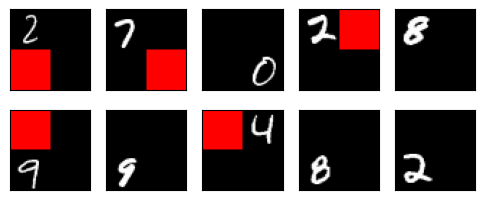

In [12]:
# Visualize samples from the zero-shot classification dataset
eval_df = pd.read_pickle('data/example_eval.pkl')
print("Zero-shot classification dataset elements:")
display(eval_df.head())

eval_metadata = json.load(open('data/example_eval_metadata.json'))
print('Zero-shot classification dataset metadata:', eval_metadata)

fig, axes = plt.subplots(2, 5, figsize=(6, 2)) 
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.05, wspace=0.2)
for idx, pixel_data in enumerate(eval_df['pixel_data'][0:10]): 
      axes[idx//5, idx%5].imshow(np.transpose(pixel_data, (1,2,0)))
      axes[idx//5, idx%5].get_xaxis().set_visible(False)
      axes[idx//5, idx%5].get_yaxis().set_visible(False)
print('Zero-shot classification dataset samples:')
plt.show()

We now use the vision encoder of the VLM to generate image-level embeddings for each image in the zero-shot classification evaluation dataset. For the purposes of this demo notebook, pre-computed image embeddings are provided in ``eval_df``.

In [13]:
img_embs = np.concatenate(eval_df['img_emb'].values.tolist())
print(img_embs.shape)

(1000, 1024)

Given image-level embeddings for each image in the dataset, we perform zero-shot classification. 

In [14]:
img_pred_label, img_score_dist = zero_shot_cls(
    img_embs=img_embs,
    model_id='clip-rn50',
    class_labels=eval_metadata['class_labels'],
    get_templates=get_templates_for_mnist(),
)


Compute zero-shot classification metrics.

In [15]:
eval_df['img_pred_label'] = img_pred_label
print("Overall Zero-Shot Classification Accuracy:", (eval_df['img_pred_label'] == eval_df['true_label']).mean())
cls_acc = {}
for c in eval_metadata['class_labels']: 
    sub_df = eval_df[eval_df['true_label']==c]
    cls_acc[c] = (sub_df['img_pred_label'] == sub_df['true_label']).mean()
print("Zero-Shot Classification Accuracy per class:", cls_acc)

Overall Zero-Shot Classification Accuracy: 0.782

Zero-Shot Classification Accuracy per class:
{
    'zero': 0.989247311827957,
    'one': 0.5371900826446281,
    'two': 0.8877551020408163,
    'three': 1.0,
    'four': 0.8367346938775511,
    'five': 0.85,
    'six': 0.8857142857142857,
    'seven': 0.8240740740740741,
    'eight': 0.5510204081632653,
    'nine': 0.5436893203883495
}

## Step 2: Perform region-level zero-shot classification using the evaluation dataset

We use the vision encoder of the VLM to generate region-level embeddings for each image in the zero-shot classification evaluation dataset. For the purposes of this demo notebook, pre-computed region embeddings are provided in ``eval_df``.

In [16]:
reg_embs = np.concatenate(eval_df['reg_emb'].values.tolist())
print(reg_embs.shape)

(4000, 1024)

Given region-level embeddings for each image in the dataset, we perform zero-shot classification at the region-level. 

In [17]:
reg_pred_label, reg_score_dist = zero_shot_cls(
    img_embs=reg_embs,
    model_id='clip-rn50',
    class_labels=eval_metadata['class_labels'],
    get_templates=get_templates_for_mnist(),
)

We now compute zero-shot classification accuracy metrics on regions containing "core" features (namely, the digit regions in this case). We note that this cell is provided purely for evaluation purposes, and prior knowledge of which regions contain core features is not necessay for RaVL to operate.

In [18]:
reg_true_label = np.concatenate(eval_df["reg_labels"].values.tolist())
idx = np.where(np.in1d(reg_true_label, eval_metadata['class_labels']))[0]
core_reg_true_label = reg_true_label[idx]
core_reg_pred_label = reg_pred_label[idx]

print("Overall Zero-Shot Region Classification Accuracy:", (core_reg_true_label == core_reg_pred_label).mean())
cls_acc = {}
for c in eval_metadata['class_labels']: 
    cls_idx = np.where(core_reg_true_label==c)[0]
    cls_acc[c] = (core_reg_true_label[cls_idx] == core_reg_pred_label[cls_idx]).mean()
print("Zero-Shot Region Classification Accuracy per class:", cls_acc)

Overall Zero-Shot Region Classification Accuracy: 0.905

Zero-Shot Region Classification Accuracy per class:
{
    'zero': 0.989247311827957,
    'one': 1.0,
    'two': 1.0,
    'three': 1.0,
    'four': 0.9897959183673469,
    'five': 0.9875,
    'six': 0.9809523809523809,
    'seven': 0.9537037037037037,
    'eight': 0.9795918367346939,
    'nine': 0.1941747572815534
}

## Step 3: Use RaVL to discover spurious correlations

Now that we have obtained the predicted labels and score distributions for all images and regions, we can run RaVL in order to discover spurious correlations.

In [19]:

ranked_region_idx, table = discover(
    reg_embs,
    eval_df['true_label'].values,
    img_pred_label,
    img_score_dist,
    reg_score_dist,
    eval_df["num_regions"].values.tolist(),
)

=> Starting RaVL Discovery - Step 1: Cluster visually similar regions

=> Running KMedoids with 20 to 49 clusters

100%|██████████| 30/30 [00:05<00:00,  5.86it/s]


Selected 47 clusters (silhouette score = 0.588)

=> Starting RaVL Discovery - Step 2: Identify image features contributing to classification errors

=> Starting RaVL Discovery - Step 3: Rank image features by degree of learned spurious correlation

## Step 4: Summarize Results

RaVL discovered a spurious correlation between the following image feature and textual attribute:

Image feature (top ten ranked regions discovered by RaVL):

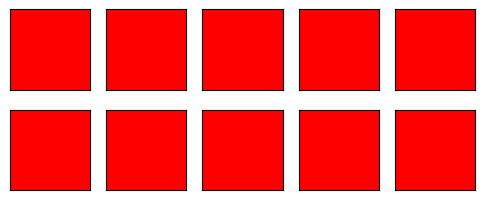

Textual attribute:

nine

Subgroup Performance Gaps:

+-------------+----------------------------------+---------------------------------+
| Image Label | Accuracy when feature is present | Accuracy when feature is absent |
+-------------+----------------------------------+---------------------------------+
|     nine    |         1.0 (54 samples)         |        0.041 (49 samples)       |
|     one     |         0.0 (56 samples)         |         1.0 (65 samples)        |
|    three    |         1.0 (37 samples)         |         1.0 (59 samples)        |
|     two     |        0.694 (36 samples)        |         1.0 (62 samples)        |
|    seven    |        0.69 (58 samples)         |        0.98 (50 samples)        |
|     zero    |        0.981 (52 samples)        |         1.0 (41 samples)        |
|    eight    |        0.023 (43 samples)        |        0.964 (55 samples)       |
|     five    |        0.684 (38 samples)        |         1.0 (42 samples)        |
|     six     |        0.782 (55 samples)        |         1.0 (50 samples)        |
|     four    |        0.644 (45 samples)        |         1.0 (53 samples)        |
+-------------+----------------------------------+---------------------------------+

In [20]:
print("RaVL discovered a spurious correlation between the following image feature and textual attribute:")
print("Image feature (top ten ranked regions discovered by RaVL):")

idxs = torch.split(torch.arange(eval_df['num_regions'].sum()), eval_df['num_regions'].values.tolist())
eval_df['reg_idx'] = [i.numpy() for i in idxs]

fig, axes = plt.subplots(2, 5, figsize=(6, 2)) 
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.05, wspace=0.2)
for idx, region_id in enumerate(ranked_region_idx[0:10]): 
    sub_df = eval_df[eval_df['reg_idx'].apply(lambda x: region_id in x)]
    img_pixel_data = sub_df['pixel_data'].values[0]
    reg_coord = sub_df['region_coord'].values[0][sub_df['reg_idx'].values[0].tolist().index(region_id)]
    reg_pixel_data = img_pixel_data[:,reg_coord[1]:reg_coord[3],reg_coord[0]:reg_coord[2]]

    axes[idx//5, idx%5].imshow(np.transpose(reg_pixel_data, (1,2,0)))
    axes[idx//5, idx%5].get_xaxis().set_visible(False)
    axes[idx//5, idx%5].get_yaxis().set_visible(False)
plt.show()


print("Textual attribute:")
df = pd.DataFrame(table.rows, columns=table.field_names)
attr = df['image-label'][(df['acc-present'].apply(lambda x: float(x.split('(')[0])) - df['acc-absent'].apply(lambda x: float(x.split('(')[0]))).argmax()]
print(attr) 

print("Subgroup Performance Gaps:")
table.field_names = [
        "Image Label",
        "Accuracy when feature is present", 
        "Accuracy when feature is absent"
]
print(table)

